In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

from network import Network
from pinn import Pinn

In [4]:
N_train = 3000
N_test = 1000

t = tf.random.uniform((N_train, 1), 0, 1)
x = tf.random.uniform((N_train, 1), -1, 1)
tx = tf.concat([t, x], axis=1)

t0 = tf.zeros((N_train, 1))
x0 = tf.random.uniform((N_train, 1), -1, 1)
tx0 = tf.concat([t0, x0], axis=1)

tb = tf.random.uniform((N_train, 1), 0, 1)
xb = -1 + 2*tf.keras.backend.random_bernoulli((N_train, 1), p=0.5)
txb = tf.concat([tb, xb], axis=1)

inputs = [tx, tx0, txb]

In [5]:
def u0fun(tx, a=np.pi):
    t, x = tx[..., 0, None], tx[..., 1, None]
    return np.sin(a*x)

In [6]:
res = np.zeros((N_train, 1))
u0 = u0fun(tx0)
# u_t0 = np.zeros((N_train, 1))  # Not necessary, in theory
u_b = np.zeros((N_train, 1))

outputs = [res, res, u0, u_b]

x_train = [tf.constant(x, dtype='float32') for x in inputs]
y_train = [tf.constant(y, dtype='float32') for y in outputs]

In [7]:
model = Network.build(hid_neurons=[16])
pinn = Pinn(model, c=1.0).pinn

In [11]:
pinn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='mse')

In [12]:
pinn.fit(x=x_train, y=y_train, batch_size=32, epochs=200)

Epoch 1/200
94/94 [==============================] - 7s 2ms/step - loss: 0.0818 - tf.__operators__.add_loss: 0.0132 - tf.math.subtract_loss: 0.0172 - gradient_layer_loss: 0.0362 - gradient_layer_1_loss: 0.0151
Epoch 2/200
94/94 [==============================] - 0s 3ms/step - loss: 0.0812 - tf.__operators__.add_loss: 0.0129 - tf.math.subtract_loss: 0.0167 - gradient_layer_loss: 0.0366 - gradient_layer_1_loss: 0.0150
Epoch 3/200
94/94 [==============================] - 0s 3ms/step - loss: 0.0807 - tf.__operators__.add_loss: 0.0132 - tf.math.subtract_loss: 0.0167 - gradient_layer_loss: 0.0359 - gradient_layer_1_loss: 0.0149
Epoch 4/200
94/94 [==============================] - 0s 3ms/step - loss: 0.0805 - tf.__operators__.add_loss: 0.0133 - tf.math.subtract_loss: 0.0168 - gradient_layer_loss: 0.0358 - gradient_layer_1_loss: 0.0147
Epoch 5/200
94/94 [==============================] - 0s 3ms/step - loss: 0.0800 - tf.__operators__.add_loss: 0.0128 - tf.math.subtract_loss: 0.0161 - gradient_l

1/1 [==============================] - 0s 17ms/step


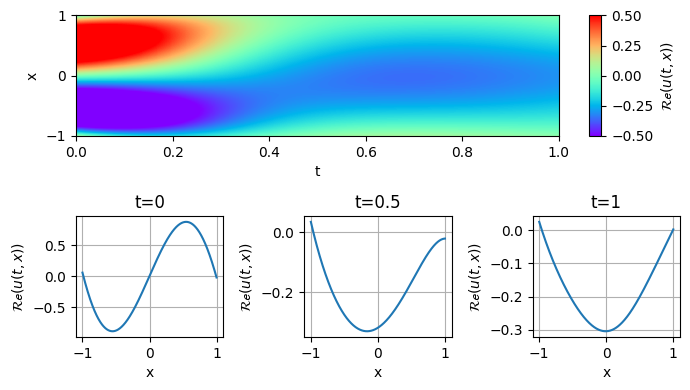

In [14]:
t_flat = np.linspace(0, 1, N_test)
x_flat = np.linspace(-1, 1, N_test)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)
u, v = model.predict(tx, batch_size=N_test)
u = u.reshape(t.shape)

# ### plot u(t,x) distribution as a color-map
fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 3)
plt.subplot(gs[0, :])
vmin, vmax = -0.5, +0.5
plt.pcolormesh(t, x, u, cmap='rainbow', norm=Normalize(vmin=vmin, vmax=vmax))
plt.xlabel('t')
plt.ylabel('x')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label(r'$\mathcal{Re}(u(t,x))$')
cbar.mappable.set_clim(vmin, vmax)

# ### plot u(t=const, x) cross-sections
t_cross_sections = [0, 0.5, 1]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[1, i])
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u, v = model.predict(tx, batch_size=N_test)
    plt.plot(x_flat, u)
    plt.title('t={}'.format(t_cs))
    plt.xlabel('x')
    plt.ylabel(r'$\mathcal{Re}(u(t,x))$')
    plt.grid()
plt.tight_layout()
plt.savefig('result_img_neumann.png', transparent=True)
plt.show()